In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from helpers import *
%load_ext autoreload
%autoreload 2

# Data input

In [53]:
data_path = 'train.csv'
y, tx, ids = load_csv_data(data_path)
y_t, tx_t, ids_t = load_csv_data(data_path)

# Clean data and initialization

In [62]:
n_para = len(tx[0]) #number of parameters/features
n_data = len(ids)   #number of data/measurements
n_t_data = len(ids_t)
w0 = np.zeros(n_para+1)

#data cleaning

def clean(x):
    for ci in range(len(x[0])):
        tmp = x[:,ci]
        tmp[tmp == -999] = np.mean(tmp[tmp != -999])
        tmp = tmp - np.mean(tmp)
        tmp = tmp/np.std(tmp)
        x[:,ci] = tmp
    x = np.concatenate((np.ones((len(tmp),1)), x), axis=1)
    return x
x = clean(tx.copy())
x_t = clean(tx_t.copy())

print(np.std(x,axis=0))
print(x.shape)
st_size = 1/(0.00005*np.max(np.linalg.eig(x.T.dot(x))[0]))
n_iter = 5000
st_size = 0.625
print(st_size)
print(n_data)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
(250000, 31)
0.625
250000


# Logistic model

In [63]:
#basic functions
sigmoid = lambda x: 1./(1.+np.exp(-x))
f_logistic = lambda y,x,w,window=np.arange(n_data): -np.sum(np.log(sigmoid(y[window]*np.dot(x[window],w))), axis=0)/len(window)
gradf_logistic = lambda y,x,w,window=np.arange(n_data): (-x[window].T.dot((1. - sigmoid(y[window]*(x[window].dot(w)))) * y[window]))/len(window)
#f_logistic = lambda y,x,w,window=np.arange(n_data): -np.sum(np.log(sigmoid(y[i]*np.dot(x[i],w))) for i in window)
#gradf_logistic = lambda y,x,w,window=np.arange(n_data): np.sum([(1. - sigmoid(y[i]*(x[i].dot(w)))) * y[i] *x[i] for i in window], axis=0)/len(window)

#testing
#print(f_logistic(y,x,w0))
#print(gradf_logistic(y,x,w0))

# GD

In [76]:
def GD(w0, st_size, f, gradf, n):
    ws = np.zeros((n+1,n_para+1))
    L = np.zeros((n+1,1))
    ws[0] = w0
    L[0] = f(y,x,ws[0])
    for i in range(n):
        ws[i+1] = ws[i] - st_size*gradf(y, x, ws[i])
        L[i+1] = f(y,x,ws[i])
    return ws, L
    
ws, L= GD(w0, st_size, f_logistic, gradf_logistic,n_iter)

In [25]:
#print((L[n]-L[n-1])/L[n])
# print(np.max(abs(ws[n_iter]-ws[n_iter-1])))
# print(L[n_iter])
# print(ws[n_iter])

# SGD

In [72]:
n_sample = 1
n_SGD = 100
def SGD(w0, st_size, f, gradf, n):
    ws = np.zeros((n+1, n_para+1))
    L = np.zeros((n+1, 1))
    ws[0] = w0
    L[0] = f(y,x,ws[0], np.random.randint(0, n_data, size=n_sample))
    for i in range(n):
        #define filter
        window = np.random.randint(0, n_data, size=n_sample)
        ws[i+1] = ws[i] - st_size*gradf(y, x, ws[i], window)
        L[i+1] = f(y,x,ws[i+1], window)
    return ws, L

ws = np.zeros((n_iter+1, n_para+1))
L = np.zeros((n_iter+1, 1))################
#L = np.ones((n_iter+1, 1))*99      ##  
for i in range(n_SGD):
    (tmp_ws, tmp_L) = SGD(w0, st_size, f_logistic, gradf_logistic,n_iter)
    ws = ws + tmp_ws###########
    L = L+tmp_L##########
    #if L[n_iter]>tmp_L[n_iter]:    ##
    #    ws, L = tmp_ws, tmp_L      ##
ws, L = ws/n_SGD, L/ n_SGD############

# Plotting L vs iteration

In [77]:
# plt.plot(L)#(np.arange(n_iter+1)[::100], L[::100])
# plt.ylabel('L', fontsize=15)
# plt.xlabel('Iteration', fontsize=15)

#find the best fit ws[i_f] in the [l,r] range (especially for SGD which fluctuates)
l = 0   
#l = (n_iter+1)*9//10 #toggle this if n_iter too large
r = n_iter+1
acc = np.zeros(r-l)
for i in range(l,r):
    acc[i-l] = np.sum(predict_labels(ws[i],x_t)==y_t)/n_t_data*100
    

75.0572


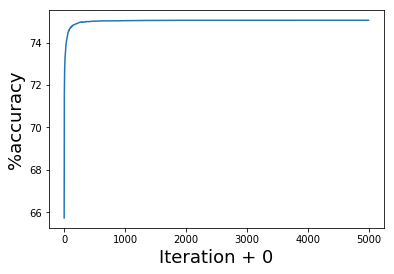

In [78]:
#plot accuracy convergence------------------------------------
plt.plot(acc)
plt.ylabel('%accuracy', fontsize=18)
plt.xlabel('Iteration + '+str(l), fontsize=18)

# check with training data-----------------------------------
i_f = np.max(np.where(acc==np.max(acc)))
wf = ws[i_f+l] #final parameter
yf = np.sign(x_t.dot(wf))
print(np.sum(yf==y_t)/n_t_data*100)
#print(i_f)

# load and test test data

In [47]:
y_test, tx_test, ids_test = load_csv_data('test.csv')

In [48]:
x_test = clean(tx_test.copy())

In [49]:
print(np.sum(predict_labels(wf,x_test)==1)*100/len(ids_test))

28.56443954821747


In [50]:
print(len(ids_test))

568238


# output

In [51]:
create_csv_submission(ids_test, predict_labels(wf,x_test), 'how_bad_can_it_get_2.csv')